In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [ ]:
cd /content/drive/MyDrive/weather_bigdata_contest/code/

/content/drive/MyDrive/weather_bigdata_contest/code


In [ ]:
sale_data_df = pd.read_csv('../data/sale_data_ohe.csv')

In [ ]:
orange_sale_data_df = sale_data_df[sale_data_df['소분류_감귤/한라봉/오렌지'] == 1]

In [ ]:
orange_sale_data_df.reset_index(drop = True, inplace = True)

In [ ]:
orange_sale_data_df[['날짜', '일별 판매 합계량(개)']]

,날짜,일별 판매 합계량(개)
0,2018-01-01,885.0
1,2018-01-02,1021.0
2,2018-01-03,1009.0
3,2018-01-04,880.0
4,2018-01-05,1080.0
...,...,...
695,2019-12-27,1308.0
696,2019-12-28,1543.0
697,2019-12-29,1425.0
698,2019-12-30,1481.0


In [ ]:
weather_data_df = pd.read_csv('../data/weather_data.csv', encoding = 'CP949')

In [ ]:
weather_data_df = weather_data_df[['일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)', '평균 상대습도(%)', 'O3', 'PM10']]

In [ ]:
# 병합하려고 했는데 날짜 column name이 달라서 '날짜'로 통일
weather_data_df.rename(columns = {'일시':'날짜'}, inplace = True)

In [ ]:
# pandas의 merge_asof method 사용하여 '날짜'를 기준으로 합치는 방법 사용하려고 했는데, '날짜'의 type이 str이라서 integer나 float으로 변경 필요
# pandas의 to_datetime method를 사용하여 type 변경
orange_sale_data_df['날짜'] = pd.to_datetime(orange_sale_data_df['날짜'], format='%Y-%m-%d')
orange_sale_data_df = orange_sale_data_df.sort_values('날짜')
weather_data_df['날짜'] = pd.to_datetime(weather_data_df['날짜'], format = '%Y-%m-%d')
weather_data_df = weather_data_df.sort_values('날짜')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# df 순서를 바꾸면 안됨
orange_df = pd.merge_asof(orange_sale_data_df, weather_data_df, on='날짜', allow_exact_matches=True)

In [ ]:
orange_df.head()

,날짜,대분류_냉난방가전,대분류_뷰티,대분류_식품,소분류_가공란,소분류_가스온수기,소분류_가열식 가습기,소분류_가자미,소분류_갈비/찜/바비큐용 돈육,소분류_갈비용 우육,소분류_갈치,소분류_감/홍시,소분류_감귤/한라봉/오렌지,소분류_감마리놀렌산 영양제,소분류_감말랭이,소분류_감자,소분류_갓김치,소분류_건강즙,소분류_건강즙/녹용,소분류_건대추,소분류_건망고,소분류_건바나나,소분류_건어물 건새우,소분류_건어물 노가리,소분류_건어물 마른오징어,소분류_건어물 멸치,소분류_건어물 쥐포,소분류_건어물 진미채,소분류_건어물 황태,소분류_건자두,소분류_건포도,소분류_게장류,소분류_견과류,소분류_견과류 땅콩,소분류_견과류 마카다미아,소분류_견과류 밤,소분류_견과류 잣/은행,소분류_견과류 카카오닙스,소분류_견과류 캐슈넛,소분류_견과류 피스타치오,...,소분류_홍삼절편/홍삼정과,소분류_홍어,소분류_홍차,소분류_화장 비누,소분류_화장 퍼프,소분류_환자식,소분류_황토매트,소분류_회,소분류_휴대용 선풍기,소분류_흰우유,소분류_히터,20대 남성 판매량(개),20대 여성 판매량(개),30대 남성 판매량(개),30대 여성 판매량(개),40대 남성 판매량(개),40대 여성 판매량(개),50대 남성 판매량(개),50대 여성 판매량(개),60대 남성 판매량(개),60대 여성 판매량(개),일별 판매 합계량(개),일별 물품 선호도 점수,20대 남성 선호도 점수,20대 여성 선호도 점수,30대 남성 선호도 점수,30대 여성 선호도 점수,40대 남성 선호도 점수,40대 여성 선호도 점수,50대 남성 선호도 점수,50대 여성 선호도 점수,60대 남성 선호도 점수,60대 여성 선호도 점수,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10
0,2018-01-01,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,33.0,105.0,68.0,179.0,99.0,223.0,43.0,104.0,7.0,22.0,885.0,0.000230,0.081053,0.087105,0.077665,0.082657,0.120986,0.125849,0.107601,0.136987,0.054336,0.125761,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069
1,2018-01-02,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,21.0,82.0,86.0,211.0,119.0,275.0,62.0,132.0,15.0,16.0,1021.0,0.000265,0.044743,0.059008,0.085205,0.084519,0.126152,0.134625,0.134582,0.150823,0.101002,0.079340,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579
2,2018-01-03,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,30.0,68.0,88.0,212.0,139.0,252.0,48.0,129.0,10.0,31.0,1009.0,0.000273,0.062158,0.047586,0.084785,0.082581,0.143296,0.119968,0.101323,0.143336,0.065480,0.149487,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134
3,2018-01-04,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,13.0,51.0,76.0,211.0,118.0,237.0,55.0,95.0,9.0,13.0,880.0,0.000217,0.033847,0.044848,0.092013,0.103283,0.152863,0.141780,0.145891,0.132645,0.074055,0.078775,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343
4,2018-01-05,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,38.0,58.0,81.0,250.0,89.0,301.0,51.0,159.0,16.0,35.0,1080.0,0.000297,0.072388,0.037317,0.071751,0.089535,0.084356,0.131746,0.098979,0.162431,0.096324,0.155173,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526


In [ ]:
pref_category = ['pref_' + str(i) + '_' + j for i in range(20, 70, 10) for j in ['M', 'F']]

pref_category_k = [str(i) + '대 ' + j + ' 선호도 점수' for i in range(20, 70, 10) for j in ['남성', '여성']]

In [ ]:
for i in range(len(pref_category)):
    globals()['orange_{}_df'.format(pref_category[i])] = orange_df[['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최소 상대습도(%)', '평균 상대습도(%)', 'O3', 'PM10', '{}'.format(pref_category_k[i])]]

In [ ]:
orange_pref_20_F_df.head()

,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10,20대 여성 선호도 점수
0,0.066157,-3.463993,4.734708,20.763179,41.267581,0.015544,44.032069,0.087105
1,-0.000201,-3.617037,4.293367,25.960511,47.229263,0.013179,53.742579,0.059008
2,-2.328937,-4.948951,1.733667,27.184564,39.916465,0.017566,34.601134,0.047586
3,-2.419582,-6.149132,1.320985,31.627278,44.077518,0.011983,42.672343,0.044848
4,-0.734189,-3.487800,3.788739,30.797391,50.195533,0.011894,51.988526,0.037317


In [ ]:
def data_preparation(df, days_before):
    temp = df.values
    X = []
    y = []
    for i in range(len(df) - days_before):
        X.append(temp[i:i + days_before])
        y.append(temp[i + days_before, -1])
    split_len = int(len(X) * 0.7)
    X_train = np.array(X[:split_len])
    X_test = np.array(X[split_len:])
    y_train = np.array(y[:split_len])
    y_test = np.array(y[split_len:])
    return X_train, X_test, y_train, y_test

In [ ]:
def create_gru():
    model = tf.keras.models.Sequential([
        keras.layers.GRU(128, input_shape = (7, 8), return_sequences = True), 
        keras.layers.GRU(96, return_sequences = False), 
        keras.layers.Dense(64), 
        keras.layers.Dense(1),  
    ])
    model.compile(
        optimizer = 'adam', 
        loss = 'mean_squared_error'
    )
    return model

In [ ]:
gru = create_gru()

In [ ]:
gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 128)            52992     
_________________________________________________________________
gru_1 (GRU)                  (None, 96)                65088     
_________________________________________________________________
dense (Dense)                (None, 64)                6208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 124,353
Trainable params: 124,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def gru_train_predict(df):
    gru = create_gru()
    X_train, X_test, y_train, y_test = data_preparation(df, days_before = 7)
    history = gru.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), shuffle = False)
    yhat = gru.predict(X_test)
    return gru, yhat, y_train, y_test, history

In [ ]:
for i in pref_category:
    globals()['gru_{}'.format(i)], globals()['yhat_{}'.format(i)], globals()['y_train_{}'.format(i)], globals()['y_test_{}'.format(i)], globals()['history_{}'.format(i)] = gru_train_predict(globals()['orange_{}_df'.format(i)])

Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.4864 - val_loss: 0.1576
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.2245 - val_loss: 0.3952
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.1199 - val_loss: 0.0410
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0668 - val_loss: 0.0021
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.0261
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 8/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 9/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 7.3908e-04
Epoch 10/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.

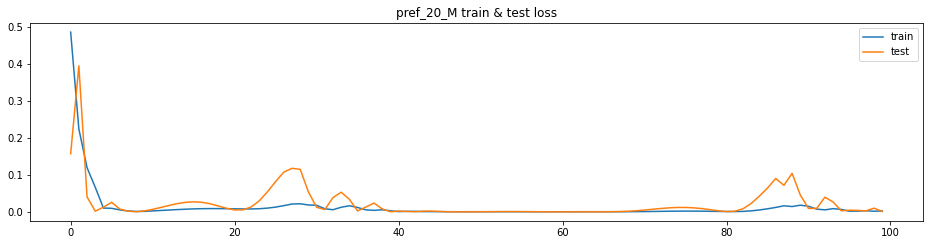

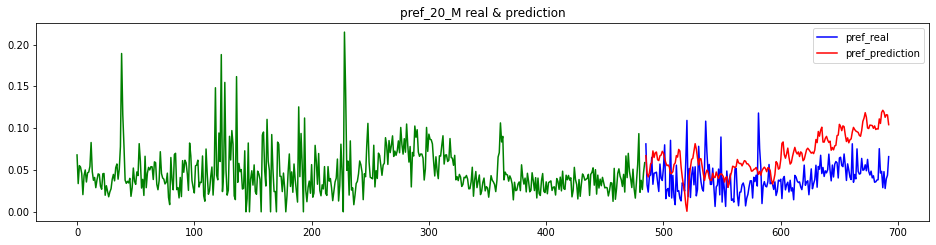

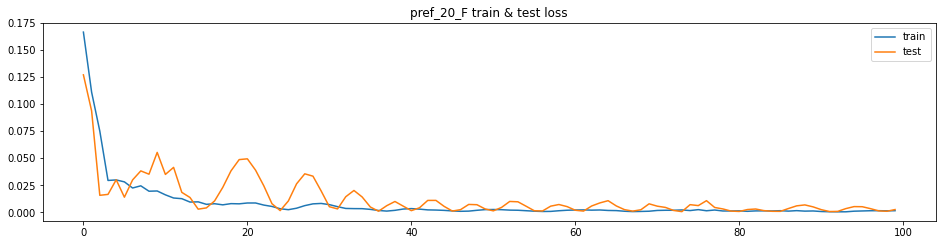

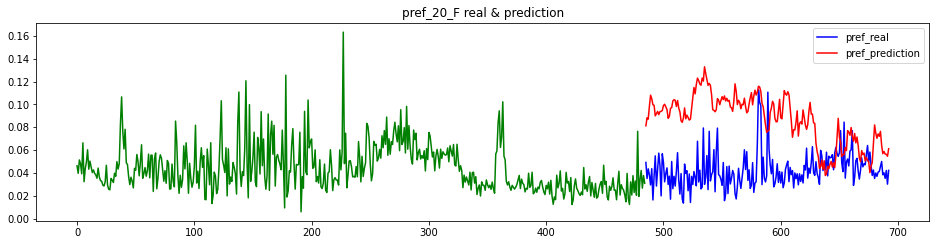

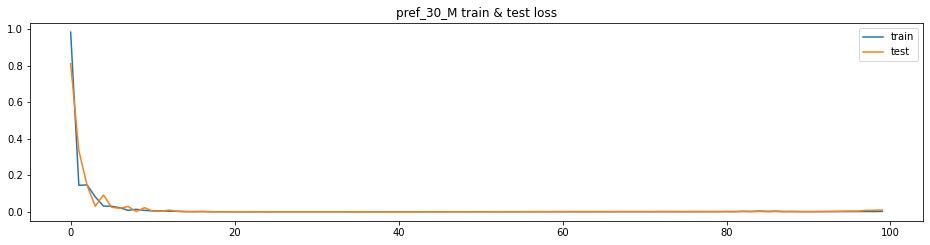

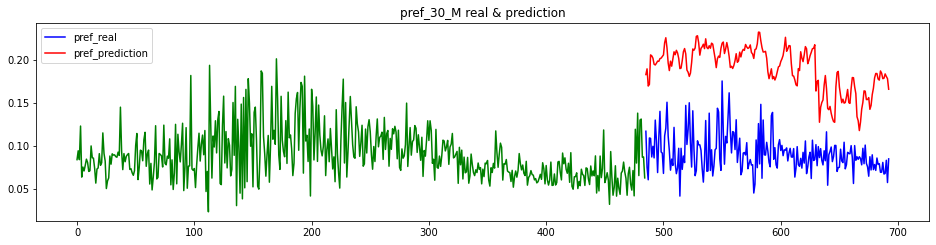

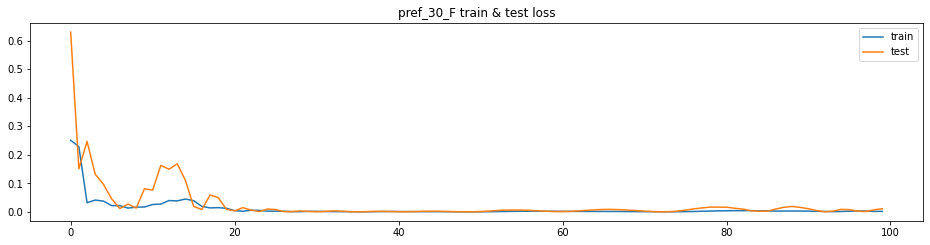

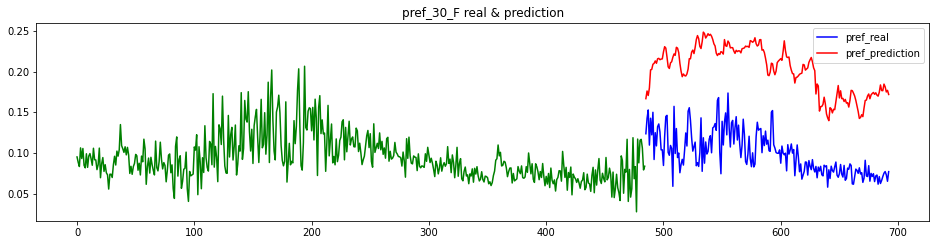

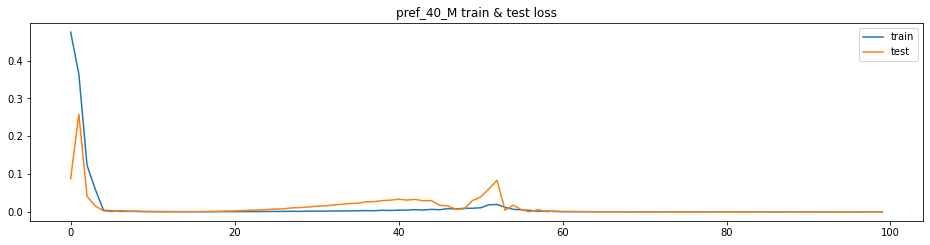

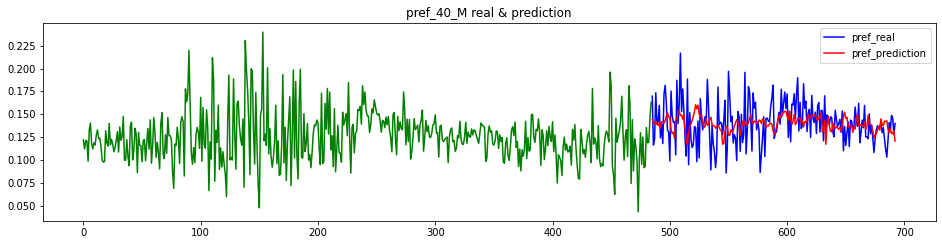

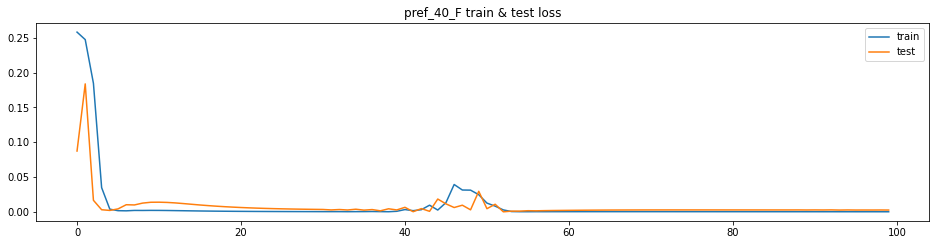

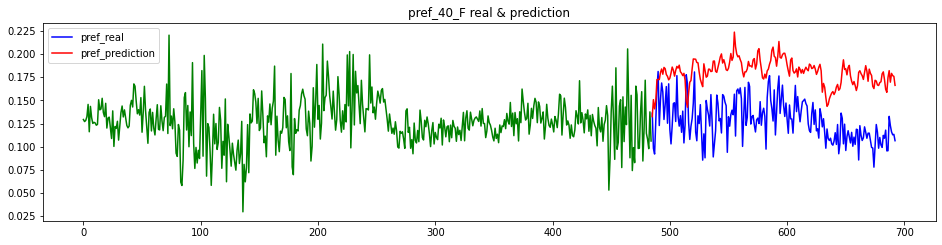

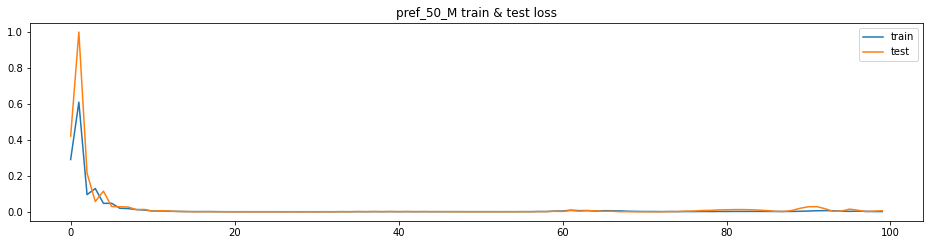

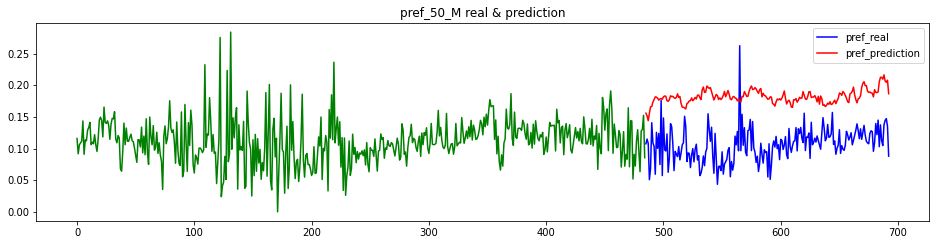

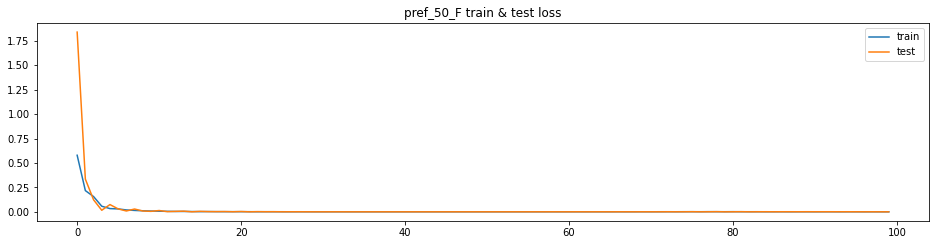

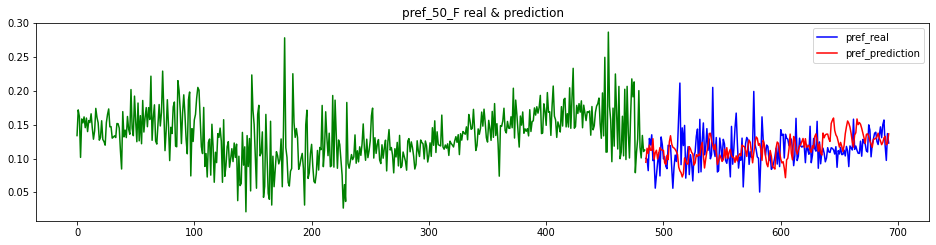

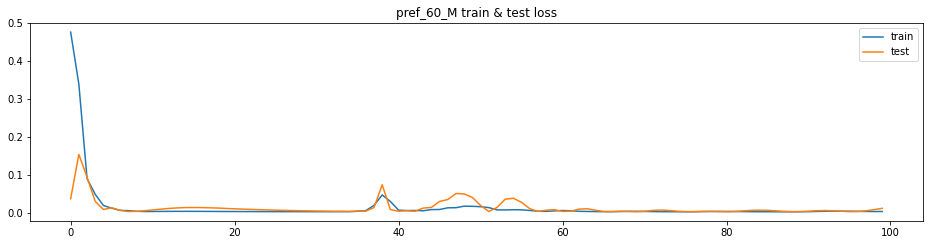

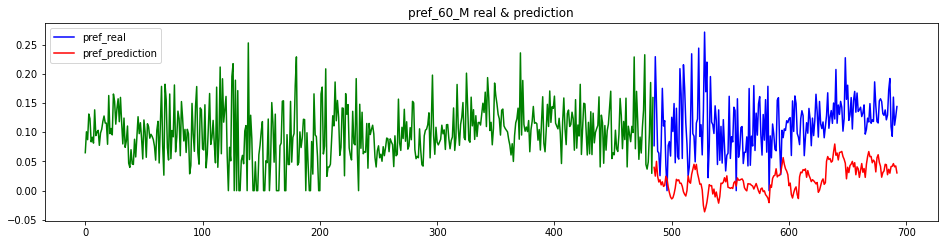

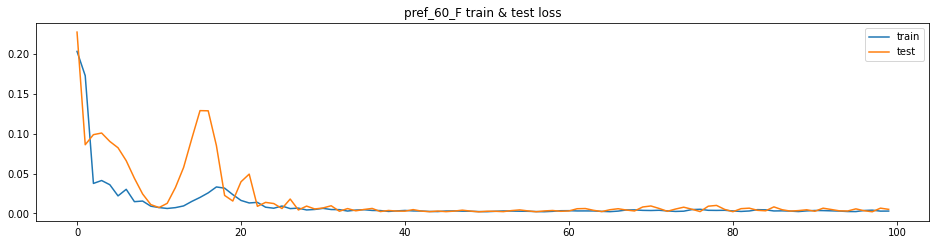

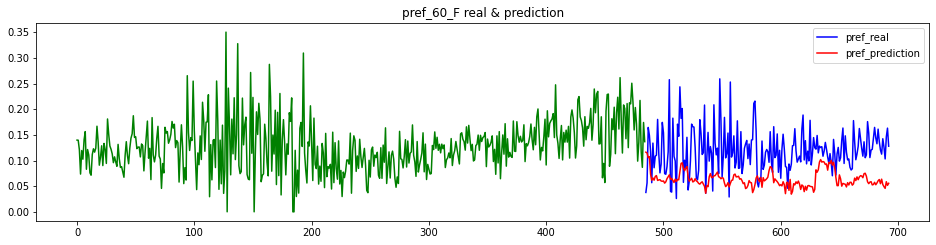

In [ ]:
for i in pref_category:
    plt.figure(figsize = (16, 8))
    plt.subplot(211)
    plt.plot(globals()['history_{}'.format(i)].history['loss'], label = 'train')
    plt.plot(globals()['history_{}'.format(i)].history['val_loss'], label = 'test')
    plt.legend()
    plt.title('{} train & test loss'.format(i))
    plt.show()

    plt.figure(figsize = (16, 8))
    plt.subplot(212)
    plt.plot(range(0, 485), globals()['y_train_{}'.format(i)], color = 'green')
    plt.plot(range(485, 485 + 208), globals()['y_test_{}'.format(i)], color = 'blue', label = 'pref_real')
    plt.plot(range(485, 485 + 208), globals()['yhat_{}'.format(i)], color = 'red', label = 'pref_prediction')
    plt.legend()
    plt.title('{} real & prediction'.format(i))
    plt.show()

In [ ]:
pref_prediction = []
pref_real = []
for i in pref_category:
    pref_prediction.append(globals()['yhat_{}'.format(i)])
    pref_real.append(globals()['y_test_{}'.format(i)])

In [ ]:
rmse = sqrt(mean_squared_error(np.array(pref_prediction).reshape(10, 208).T, np.array(pref_real).reshape(10, 208).T))

print('RMSE value: {}'.format(rmse))

RMSE value: 0.07314881180759451
